# Final Project - Visuals & Plots
Kalyn Howes & Chloe VanCory

COSC 311

12.15.21

Feature visualizations.

##### Imports

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import copy
import tqdm
from collections import Counter
from sklearn.metrics import confusion_matrix
from datetime import datetime 
import seaborn as sns

### Prepping Spotify Data

In [ ]:
songs = pd.read_csv('Data/Spotify.csv', header=0)
print(f'Data Information:\nShape: {songs.shape}')
songs.head()

Data Information:
Shape: (1556, 23)


,Index,Highest Charting Position,Number of Times Charted,Week of Highest Charting,Song Name,Streams,Artist,Artist Followers,Song ID,Genre,...,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord
0,1,1,8,2021-07-23--2021-07-30,Beggin',"48,633,449",Måneskin,3377762,3Wrjm47oTz2sjIgck11l5e,"['indie rock italiano', 'italian pop']",...,0.714,0.8,-4.808,0.0504,0.127,0.359,134.002,211560,0.589,B
1,2,2,3,2021-07-23--2021-07-30,STAY (with Justin Bieber),"47,248,719",The Kid LAROI,2230022,5HCyWlXZPP0y6Gqq8TgA20,['australian hip hop'],...,0.591,0.764,-5.484,0.0483,0.0383,0.103,169.928,141806,0.478,C#/Db
2,3,1,11,2021-06-25--2021-07-02,good 4 u,"40,162,559",Olivia Rodrigo,6266514,4ZtFanR9U6ndgddUvNcjcG,['pop'],...,0.563,0.664,-5.044,0.154,0.335,0.0849,166.928,178147,0.688,A
3,4,3,5,2021-07-02--2021-07-09,Bad Habits,"37,799,456",Ed Sheeran,83293380,6PQ88X9TkUIAUIZJHW2upE,"['pop', 'uk pop']",...,0.808,0.897,-3.712,0.0348,0.0469,0.364,126.026,231041,0.591,B
4,5,5,1,2021-07-23--2021-07-30,INDUSTRY BABY (feat. Jack Harlow),"33,948,454",Lil Nas X,5473565,27NovPIUIRrOZoCHxABJwK,"['lgbtq+ hip hop', 'pop rap']",...,0.736,0.704,-7.409,0.0615,0.0203,0.0501,149.995,212000,0.894,D#/Eb


In [ ]:
songs['Chord'].unique()

array(['B', 'C#/Db', 'A', 'D#/Eb', 'G#/Ab', 'F#/Gb', 'C', 'D', 'A#/Bb',
       'G', 'E', 'F', ' '], dtype=object)

In [ ]:
genres = songs['Genre']
print(genres)

0                  ['indie rock italiano', 'italian pop']
1                                  ['australian hip hop']
2                                                 ['pop']
3                                       ['pop', 'uk pop']
4                           ['lgbtq+ hip hop', 'pop rap']
                              ...                        
1551                       ['dance pop', 'pop', 'uk pop']
1552             ['sertanejo', 'sertanejo universitario']
1553    ['dance pop', 'electropop', 'pop', 'post-teen ...
1554                       ['brega funk', 'funk carioca']
1555                             ['pop', 'post-teen pop']
Name: Genre, Length: 1556, dtype: object


Need to determine the number of classes we have / how to classify songs with more than one genre:

Create a list of umbrella genres and fit each song into them. Then create a new column in the dataframe that holds the umbrella genre for each song (row).

In [ ]:
umbrella_genres = ['indie rock', 'alternative', 'dance pop', 'latin', 'k-pop', 'reggaeton', 'alternative rock', 'comic', 'alt z',
                   'modern rock', 'melodic rap', 'folk', 'grunge', 'singer-songwriter', 'classic rock', 'edm', 'country',
                   'funk', 'pop rock', 'indie', 'metal', 'soul', 'trap', 'new wave', 'punk', 'boy band', 'swing', 'brooklyn drill',
                   'rock', 'hip hop', 'r&b', 'pop', 'rap', 'classical', 'psychedelic', 'Brazilian', 'easy listening', 'show tunes', 'jazz']

# create dictionary (in case the genres will need to be numbered): dict = { 1: 'indie rock', 2: 'alternative'}
dict = {}
count = 1
for u in umbrella_genres:
    dict[count] = u
    count += 1

print(f'Dictionary of Umbrella Genres: \n{dict}')

Dictionary of Umbrella Genres: 
{1: 'indie rock', 2: 'alternative', 3: 'dance pop', 4: 'latin', 5: 'k-pop', 6: 'reggaeton', 7: 'alternative rock', 8: 'comic', 9: 'alt z', 10: 'modern rock', 11: 'melodic rap', 12: 'folk', 13: 'grunge', 14: 'singer-songwriter', 15: 'classic rock', 16: 'edm', 17: 'country', 18: 'funk', 19: 'pop rock', 20: 'indie', 21: 'metal', 22: 'soul', 23: 'trap', 24: 'new wave', 25: 'punk', 26: 'boy band', 27: 'swing', 28: 'brooklyn drill', 29: 'rock', 30: 'hip hop', 31: 'r&b', 32: 'pop', 33: 'rap', 34: 'classical', 35: 'psychedelic', 36: 'Brazilian', 37: 'easy listening', 38: 'show tunes', 39: 'jazz'}


In [ ]:
# assign each song to its umbrella genre
umbrella_songs = []

for g in genres:
    tracker = False # debugger: determining which songs are not getting an umbrella genre
    #print(f'g: {g}')
    
    # taking care of loads of random edge cases (songs with genres that are only held by very few instances)
    if g == "[]" or g == "" or g == " ":
        #print(f'EMPTY- ADDING: ?')
        umbrella_songs.append('?')
        tracker = True
    elif g.find("basshall") != -1 or g.find("tronica") != -1 or g.find("techno") != -1 or g.find("house") != -1:
        umbrella_songs.append("edm")
        tracker = True
    elif g.find("eurovision") != -1 or g.find("advocacy") != -1 or g.find("soundtrack") != -1:
        umbrella_songs.append("pop")
        tracker = True
    elif g.find("dream smp") != -1:
        umbrella_songs.append("classical")
        tracker = True
    elif g.find("weirdcore") != -1 or g.find("psych") != -1:
        umbrella_songs.append("psychedelic")
        tracker = True
    elif g.find("forro") != -1 or g.find("piseiro") != -1 or g.find("sertanejo") != -1:
        umbrella_songs.append("Brazilian")
        tracker = True 
    elif g.find("espanol") != -1 or g.find("mariachi") != -1 or g.find("mexican") != -1:
        umbrella_songs.append("latin")
        tracker = True  
    elif g.find("a cappella") != -1 or g.find("jawaiian") != -1:
        umbrella_songs.append("easy listening")
        tracker = True   
    else:
        # for each umbrella genre: if the umbrella genre is found in g, add it to the umbrella_songs
        for u in umbrella_genres:
            if g.find(u) != -1:
                #print(f'ADDING: {u}')
                umbrella_songs.append(u)
                tracker = True
                break # make sure only 1 u is being added to a g
    
    # tracking edge cases
    # if tracker == False:
    #     print(f'NOTHING ADDED for g: {g}')

In [ ]:
# add umbrella genre column
songs = songs.assign(Umbrella_Genre = umbrella_songs)
songs.head()

,Index,Highest Charting Position,Number of Times Charted,Week of Highest Charting,Song Name,Streams,Artist,Artist Followers,Song ID,Genre,...,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord,Umbrella_Genre
0,1,1,8,2021-07-23--2021-07-30,Beggin',"48,633,449",Måneskin,3377762,3Wrjm47oTz2sjIgck11l5e,"['indie rock italiano', 'italian pop']",...,0.8,-4.808,0.0504,0.127,0.359,134.002,211560,0.589,B,indie rock
1,2,2,3,2021-07-23--2021-07-30,STAY (with Justin Bieber),"47,248,719",The Kid LAROI,2230022,5HCyWlXZPP0y6Gqq8TgA20,['australian hip hop'],...,0.764,-5.484,0.0483,0.0383,0.103,169.928,141806,0.478,C#/Db,hip hop
2,3,1,11,2021-06-25--2021-07-02,good 4 u,"40,162,559",Olivia Rodrigo,6266514,4ZtFanR9U6ndgddUvNcjcG,['pop'],...,0.664,-5.044,0.154,0.335,0.0849,166.928,178147,0.688,A,pop
3,4,3,5,2021-07-02--2021-07-09,Bad Habits,"37,799,456",Ed Sheeran,83293380,6PQ88X9TkUIAUIZJHW2upE,"['pop', 'uk pop']",...,0.897,-3.712,0.0348,0.0469,0.364,126.026,231041,0.591,B,pop
4,5,5,1,2021-07-23--2021-07-30,INDUSTRY BABY (feat. Jack Harlow),"33,948,454",Lil Nas X,5473565,27NovPIUIRrOZoCHxABJwK,"['lgbtq+ hip hop', 'pop rap']",...,0.704,-7.409,0.0615,0.0203,0.0501,149.995,212000,0.894,D#/Eb,hip hop


# Feature Visualizations

Features:

1. Highest Charting Position
2. Number of Times Charted
3. Week of Highest Charting
4. Streams
5. Artist
6. Artist Follower
7. Genre (Umbrella Genre)
8. Release Date 
9. Weeks Charted 
10. Popularity 
11. Danceability 
12. Energy
13. Loudness 
14. Speechiness
15. Acousticness
16. Liveness
17. Tempo
18. Duration
19. Valence
20. Chord

For at least two of these, use a non-standard graphic.

### 1, 3 & 8: Highest Charting Position, Week of Highest Charting, Release Date

In [12]:
songs.at[163,'Release Date'] = '10/30/20' # to manually modify the df

# for the top 10 songs in the list
averages=[]
for i in range(1,11):
    releasedates = songs["Release Date" ][songs["Highest Charting Position"] == i ]
    releasedates = releasedates.reset_index(drop=True)
    chartingdates = songs[ "Week of Highest Charting" ][songs["Highest Charting Position"] == i ]
    chartingdates = chartingdates.reset_index(drop=True)
    chartingdates = [dates.split("--")[0] for dates in chartingdates ]
    releasedates = [ datetime.strptime(dates, '%m/%d/%y') for dates in releasedates ]
    chartingdates = [ datetime.strptime(dates, '%Y-%m-%d') for dates in chartingdates ]
    difference = [(l-r).days for l,r in zip(chartingdates, releasedates)]
    temp = np.array(difference).sum() / len(difference)
    averages += [ temp]
# averages

Text(0.5, 1.0, 'Number of Days After Release to be Charted (2020-2021) ')

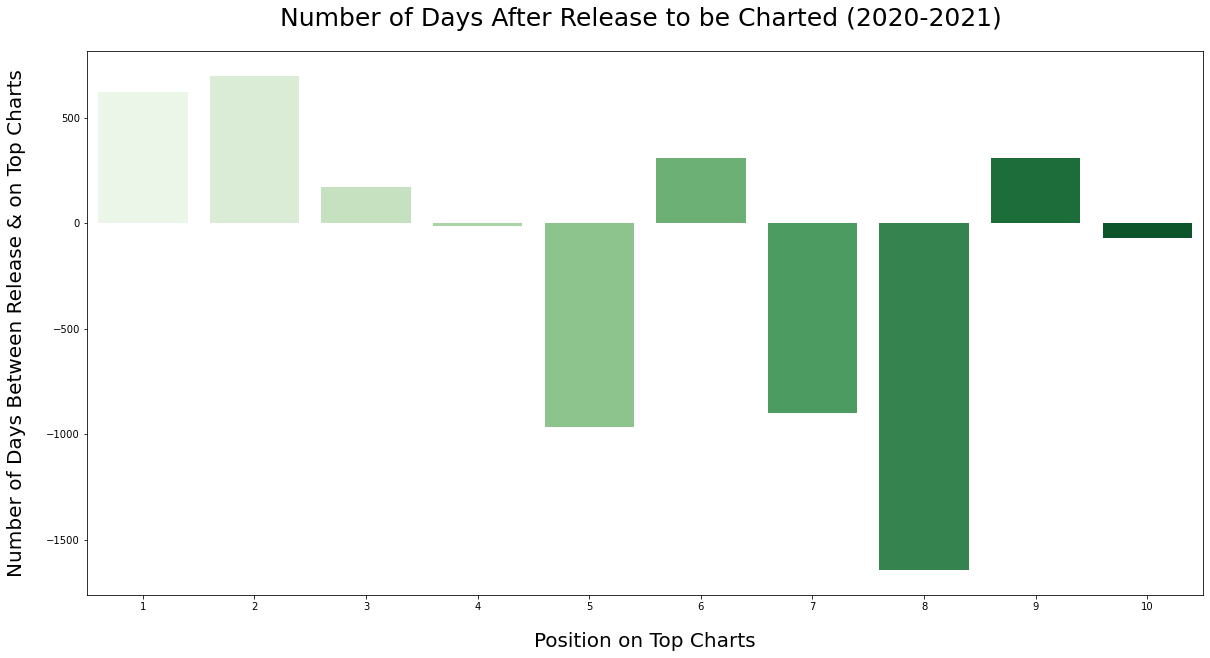

In [13]:
fig2 = plt.gcf()
fig2.set_size_inches(20, 10)

xs = [x for x in range(1,11)]
df = pd.Series(averages)

ax = sns.barplot(y = averages, x = xs , palette=("Greens"))
sns.set_context("poster")
plt.ylabel("Number of Days Between Release & on Top Charts", size =20, labelpad =20)
plt.xlabel("Position on Top Charts", size =20, labelpad =20)
plt.title("Number of Days After Release to be Charted (2020-2021) ", size=25, pad=25)

### 1, 3, & 9: Weeks Charted, Highest Charting Position, Week of Highest Charting

In [17]:
averages=[]
for i in range(1,11):
    finaldate = songs[ "Weeks Charted" ][songs["Highest Charting Position"] == i ]
    chartingdates = songs[ "Week of Highest Charting" ][songs["Highest Charting Position"] == i ]
    # split the string into a format of lists  
    finaldate = [ dates.split("--") for dates in finaldate ] # split the data to make a list of lists 
    chartingdates = [dates.split("--")[0] for dates in chartingdates ]
    # extract the last chronological date 
    finaldate = [dates [len(dates)-1] for dates in finaldate ]
    chartingdates = [dates.split("--")[0] for dates in chartingdates ]
    finaldate =  [ datetime.strptime(dates, '%Y-%m-%d') for dates in finaldate ]
    chartingdates = [ datetime.strptime(dates, '%Y-%m-%d') for dates in chartingdates ]
    timediff  = [(l-r).days for l,r in zip(chartingdates, finaldate)]
    avg = np.array(timediff).sum() / len(timediff)
    averages += [ avg ]
# averages  

Text(0.5, 1.0, 'Duration on the Top Charts (2020-2021)')

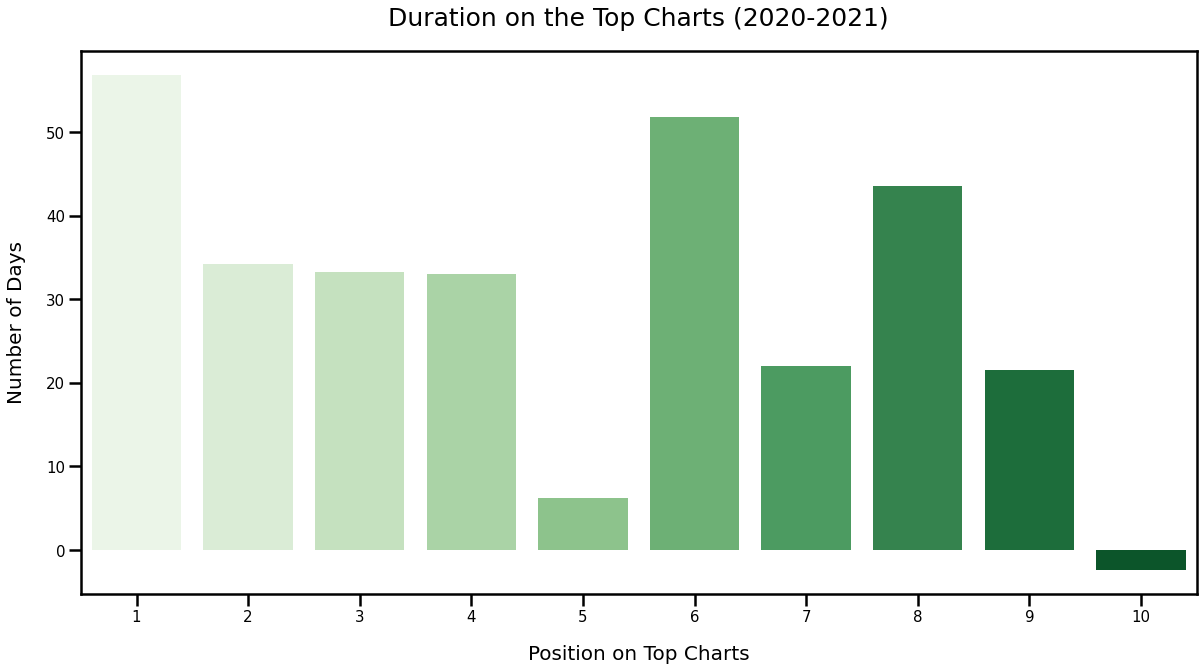

In [18]:
fig2 = plt.gcf()
fig2.set_size_inches(20, 10)

xs = [x for x in range(1,11)]
df = pd.Series(averages)

ax = sns.barplot(y = averages, x = xs , palette=("Greens"))
sns.set_context("poster")
plt.ylabel("Number of Days", size=20 , labelpad=20)
plt.xlabel("Position on Top Charts", size=20 , labelpad=20)
plt.yticks(size=15)
plt.xticks(size=15)
plt.title("Duration on the Top Charts (2020-2021)", size=25 , pad=25)

### 4: Streams

Spotify Code graph: top 20 (or so) songs with length of line dependent on # of streams

In [14]:
songs['Streams'] = np.array([int(s.replace(',','')) for s in songs['Streams'].values])
songs['Streams'][songs['Streams'] == ' '] = 0

/tmp/ipykernel_40888/1367675775.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  songs['Streams'][songs['Streams'] == ' '] = 0


In [15]:
# artists & their number of followers
# bring in followers as ints
songs['Song Name'][songs['Song Name'] == ' '] = '?'
names = songs['Song Name']

streams_dict = { names[i]: songs['Streams'][i] for i in range(len(names))}
#print(streams_dict)
streams_dict = sorted(streams_dict.items(), key=lambda x: x[1], reverse=True)
#print(streams_dict)

top20 = []
for i in range(0, 20):
    top20.append(streams_dict[i])
    
#print(top20)
x = []
y = []
for i in top20:
    x.append(i[0])
    y.append(i[1])

/tmp/ipykernel_40888/93884651.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  songs['Song Name'][songs['Song Name'] == ' '] = '?'


Text(0, 0.5, 'Song Name')

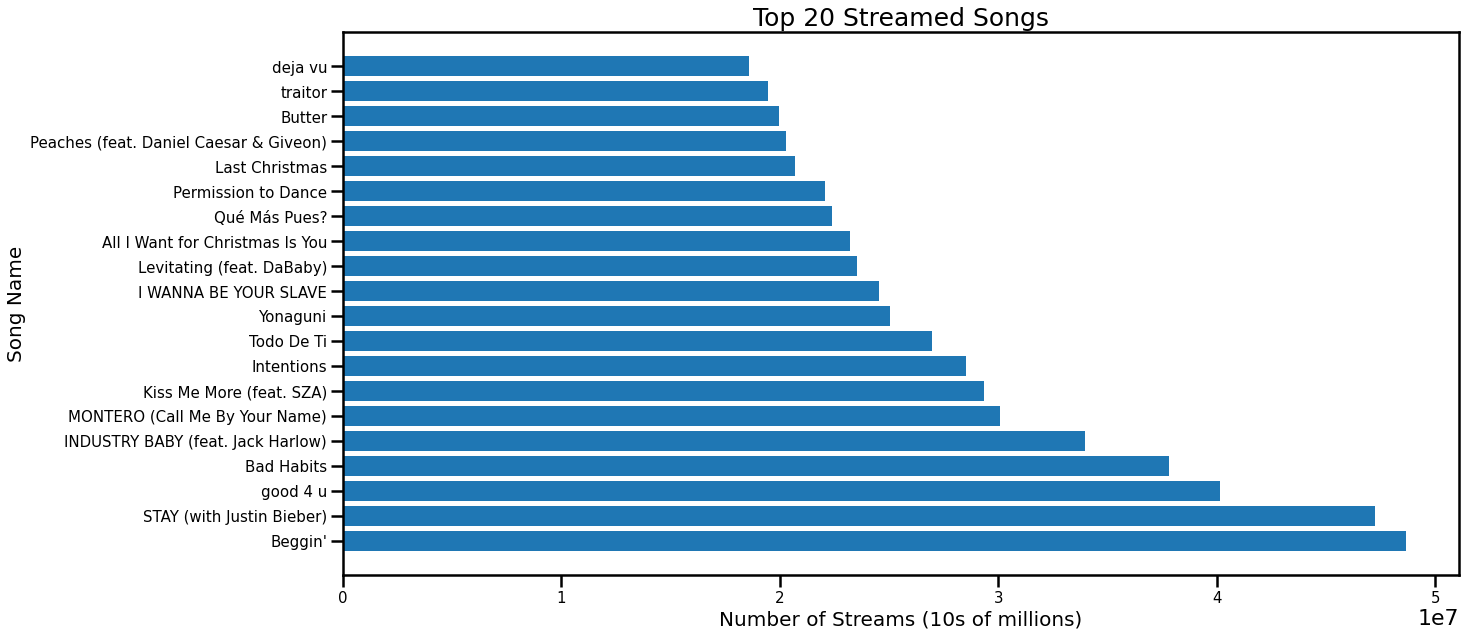

In [16]:
# actual plotting:
# for re-sizing:
fig, ax = plt.subplots()
fig = plt.gcf()
fig.set_size_inches(20, 10)

# xs = [x for x in range(1,21)]
# ax = sns.barplot(x, y, palette=("Greens"))
# sns.set_context("poster")
    
plt.barh(x, width=y)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.title("Top 20 Streamed Songs", size = 25)
plt.xlabel("Number of Streams (10s of millions)", size = 20)
plt.ylabel("Song Name", size = 20)

### 2 & 10: Number of Times Charted & Popularity

Correlation = 0.22207881429900625


/tmp/ipykernel_40888/3005493211.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  songs['Number of Times Charted'][songs['Number of Times Charted'] == ' '] = 1
/tmp/ipykernel_40888/3005493211.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  songs['Popularity'][songs['Popularity'] == ' '] = 1


Text(0, 0.5, 'Popularity (0-100)')

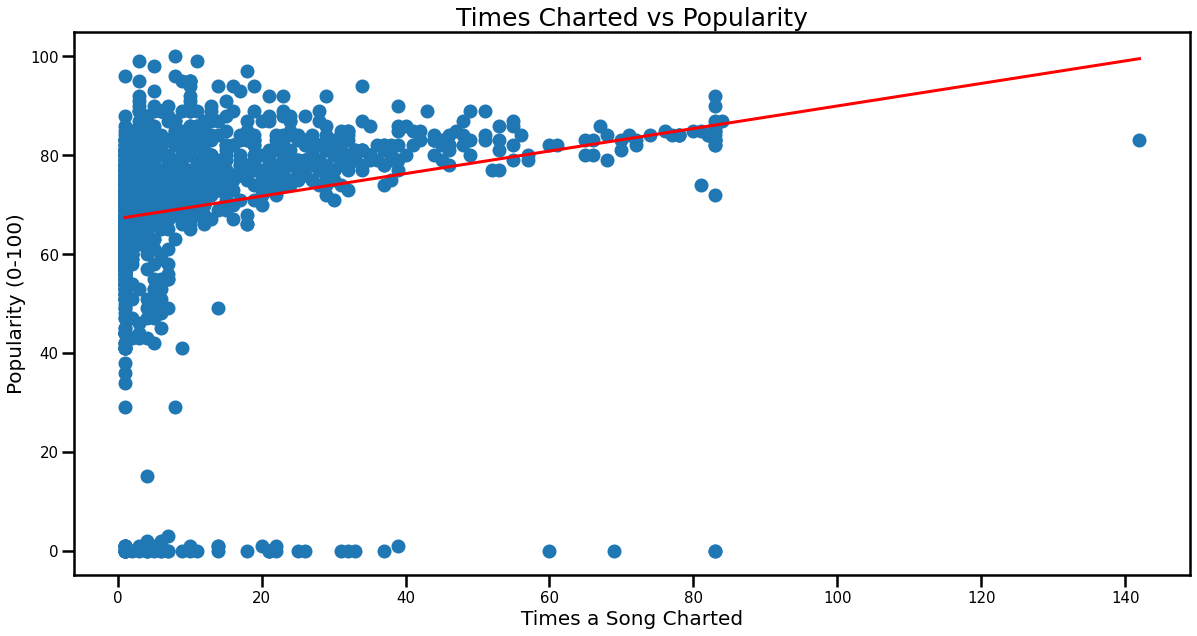

In [17]:
# bring in as ints not strings
songs['Number of Times Charted'][songs['Number of Times Charted'] == ' '] = 1
x = songs['Number of Times Charted'].astype(int)
#print(x)

songs['Popularity'][songs['Popularity'] == ' '] = 1
y = songs['Popularity'].astype(int)

correlation = x.corr(y)
print(f'Correlation = {correlation}')

# for re-sizing:
fig2 = plt.gcf()
fig2.set_size_inches(20, 10)

plt.scatter(x, y)
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color = 'r') # fit the line to the data
plt.xticks(size=15)
plt.yticks(size=15)
plt.title('Times Charted vs Popularity', size=25)
plt.xlabel('Times a Song Charted', size=20)
plt.ylabel('Popularity (0-100)', size=20)

 ### 5 & 6: Artists & Artist Followers
 Bar chart to show top 10 artists based on followers.

In [ ]:
# artists & their number of followers
# bring in followers as ints
songs['Artist Followers'][songs['Artist Followers'] == ' '] = 0
followers = songs['Artist Followers'].astype(int)

artist_dict = { songs['Artist'][i]: followers[i] for i in range(len(followers))}
artist_dict_sorted = sorted(artist_dict.items(), key=lambda x: x[1], reverse=True)
#print(artist_dict_sorted[:45])

# manually input top 10 due to duplicates
top10 = {'Ed Sheeran': 83337783,'Ariana Grande': 67208170,'Drake': 56327031,'Justin Bieber': 48544923,'Billie Eilish': 47061119,
         'Eminem': 46814751, 'Taylor Swift': 42227614, 'BTS': 37151476, 'Bad Bunny': 36177712, 'The Weeknd': 35340069}
print(top10)

In [ ]:
# actual plotting:
# for re-sizing:
fig2 = plt.gcf()
fig2.set_size_inches(20, 10)

plt.bar(x=top10.keys(), height=top10.values())
plt.xticks(rotation=90, size = 15)
plt.yticks(size = 15)
plt.title("Artist Popularity by Spotify Followers", size = 25)
plt.xlabel("Artist", size = 20)
plt.ylabel("Number of Followers (tens of millions)", size = 20)

### 7: Genre (Umbrella)
Bar chart to show which genre has the most songs on the charts.

In [ ]:
# need to count which genres show up the most: counting for histogram
s = songs.groupby('Umbrella_Genre').size()
s = s.sort_values(ascending = False)
#print(s)

top10 = s[:10]
#print(top10)

# for re-sizing:
fig2 = plt.gcf()
fig2.set_size_inches(20, 10)

# already counted - use a bar
plt.bar(x=top10.index, height=top10.values)
plt.xticks(ticks = top10.index, labels = ['Hip-Hop', 'Dance Pop', 'Latin', 'Pop', 
           'Melodic Rap', 'Trap', 'Unknown', 'EDM', 'K-Pop', 'Rap'], rotation=90, size=15)
plt.yticks(size=15)
plt.title("Genre Popularity", size = 25)
plt.xlabel("Genre", size = 20)
plt.ylabel("Number of Songs", size = 20)

### 8: Release Date
Bar chart that shows which month the most songs are released (over numerous years).

In [ ]:
releases = songs['Release Date']
#print(releases)

# need to separate each release by its month & save them in their own list
month_options = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
months = []

for r in releases:
    for m in month_options:
        if r.find('-' + m + '-') != -1:
            months.append(m)
            
months.sort()

# find counts for each month & use BAR plot instead of hist
# make dictionary that includes the counts
month_dict = {'Jan': 0, 'Feb': 0, 'Mar': 0, 'Apr': 0, 'May': 0, 'Jun': 0, 
        'Jul': 0, 'Aug': 0, 'Sep': 0, 'Oct': 0, 'Nov': 0, 'Dec': 0 }
for m in months:
    if m == '01':
        month_dict['Jan'] = month_dict['Jan'] + 1
    if m == '02':
        month_dict['Feb'] = month_dict['Feb'] + 1
    if m == '03':
        month_dict['Mar'] = month_dict['Mar'] + 1
    if m == '04':
        month_dict['Apr'] = month_dict['Apr'] + 1
    if m == '05':
        month_dict['May'] = month_dict['May'] + 1
    if m == '06':
        month_dict['Jun'] = month_dict['Jun'] + 1
    if m == '07':
        month_dict['Jul'] = month_dict['Jul'] + 1
    if m == '08':
        month_dict['Aug'] = month_dict['Aug'] + 1
    if m == '09':
        month_dict['Sep'] = month_dict['Sep'] + 1
    if m == '10':
        month_dict['Oct'] = month_dict['Oct'] + 1
    if m == '11':
        month_dict['Nov'] = month_dict['Nov'] + 1
    if m == '12':
        month_dict['Dec'] = month_dict['Dec'] + 1
    
print(month_dict)

# for re-sizing:
fig2 = plt.gcf()
fig2.set_size_inches(20, 10)

plt.bar(month_dict.keys(), month_dict.values())
plt.xticks(size=15)
plt.yticks(size=15)
plt.title("Song Releases by Month (all years)", size = 25)
plt.xlabel("Month", size = 20)
plt.ylabel("Number of Songs", size = 20)

### 11 & 12: Danceability & Energy
How do these two features correlate?

0.243163384743773


/tmp/ipykernel_40888/870714466.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  songs['Energy'][songs['Energy'] == ' '] = 0
/tmp/ipykernel_40888/870714466.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  songs['Danceability'][songs['Danceability'] == ' '] = 0


Text(0, 0.5, 'Danceability')

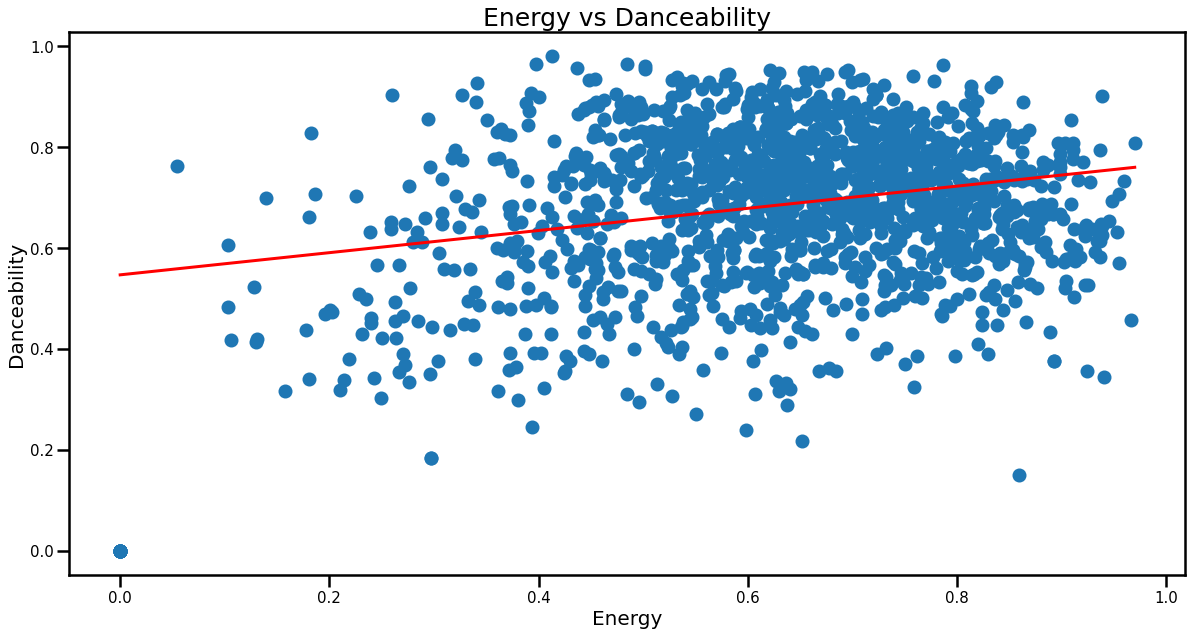

In [18]:
# both hold decimal values
#print(songs['Danceability'].unique())
#print(songs['Energy'].unique())

# bring in as ints not strings
songs['Energy'][songs['Energy'] == ' '] = 0
x = songs['Energy'].astype(float)
songs['Danceability'][songs['Danceability'] == ' '] = 0
y = songs['Danceability'].astype(float)

correlation = x.corr(y)
print(correlation)

# for re-sizing:
fig2 = plt.gcf()
fig2.set_size_inches(20, 10)

plt.scatter(x, y)
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color = 'r') # fit the line to the data
plt.xticks(size=15)
plt.yticks(size=15)
plt.title('Energy vs Danceability', size=25)
plt.xlabel('Energy', size=20)
plt.ylabel('Danceability', size=20)

### 20: Chord Special Plot (1)

In [19]:
songs['Chord'][songs['Chord'] == ' '] = '?' # replace blanks
chord_unique = songs['Chord'].unique()
chord_unique.sort()
print(chord_unique)

chords = songs['Chord']

['?' 'A' 'A#/Bb' 'B' 'C' 'C#/Db' 'D' 'D#/Eb' 'E' 'F' 'F#/Gb' 'G' 'G#/Ab']


/tmp/ipykernel_40888/1817841165.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  songs['Chord'][songs['Chord'] == ' '] = '?' # replace blanks


In [20]:
# determine which notes are used for each chord (research)
chord_dict = {
    'E': ['E', 'GS', 'B'],
    'F': ['F', 'A', 'C'],
    'F#/Gb': ['FS', 'AS', 'CS'],
    'G': ['G', 'B', 'D'],
    'G#/Ab': ['GS', 'C', 'DS'],
    'A': ['A', 'CS', 'E'],
    'A#/Bb': ['AS', 'D', 'F'],
    'B': ['B', 'DS', 'FS'],
    'C': ['C', 'E', 'G'],
    'C#/Db': ['CS', 'F', 'GS'],
    'D': ['D', 'FS', 'A'],
    'D#/Eb': ['G', 'AS', 'DS']
}

# determine the frequency of each chord & therefore the frequency of each note
chord_counts = chords.value_counts()
chord_counts = chord_counts.to_dict()
#print(chord_counts)

# dictionary to hold note frequencies
notes_num = {
    'E': 0,
    'F': 0,
    'FS': 0,
    'G': 0,
    'GS': 0,
    'A': 0,
    'AS': 0,
    'B': 0,
    'C': 0,
    'CS': 0,
    'D': 0,
    'DS': 0
}

# for each note in each chord...
for d in chord_dict:
    #print(f'NEW DICTIONARY ROW D: {d}')
    for n in chord_dict[d]:
        #print(f'chord_dict[d]: {chord_dict[d]}')
        #print(f'n: {n}')
        notes_num[n] += chord_counts[d] # chord_counts[current chord in d]
        #print(f'adding {chord_counts[d]} to note {n}')
        
notes_num = sorted(notes_num.items(), key=lambda x: x[1])
print(notes_num)

[('AS', 283), ('DS', 311), ('G', 331), ('A', 374), ('D', 383), ('E', 385), ('FS', 387), ('B', 389), ('C', 416), ('CS', 453), ('GS', 456), ('F', 467)]


In [21]:
# OPTION 1: change size of "notes" on clef based on usage

# sorted with least used note at the bottom, increase size by a threshold for each note
# dictionary to hold sizes each note should be for plotting (in order of smallest frequency to largest)
sizes = {
    'AS': 0.025,
    'DS': 0.05,
    'G': 0.075,
    'A': 0.1,
    'D': 0.125,
    'E': 0.15,
    'FS': 0.175,
    'B': 0.2,
    'C': 0.225,
    'CS': 0.25,
    'GS': 0.275,
    'F': 0.3
}

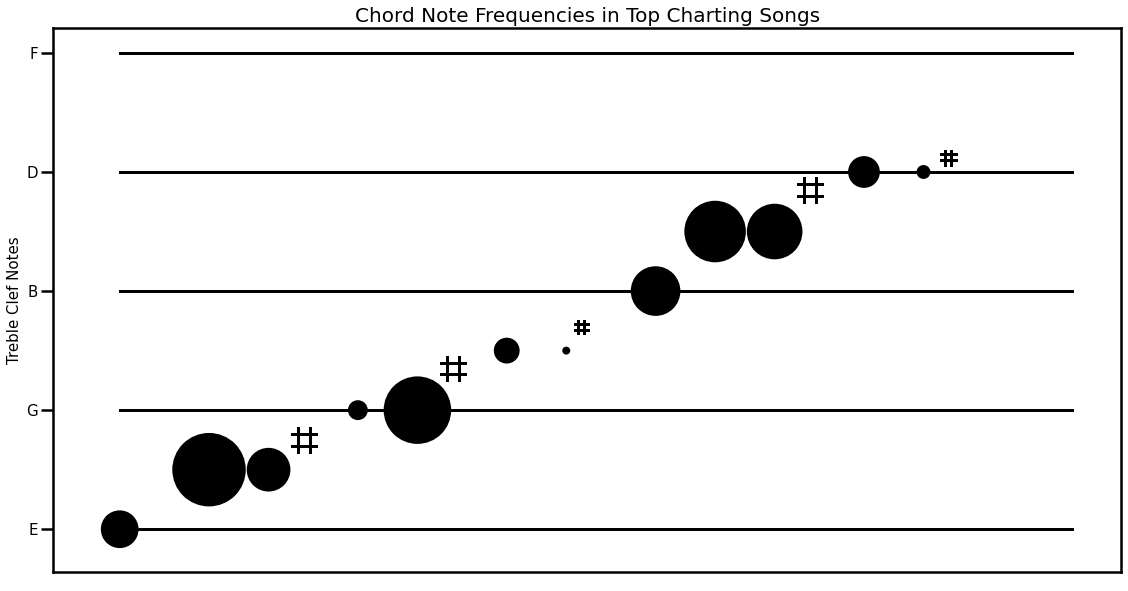

In [30]:
# figure:
fig = plt.figure()
ax = fig.gca()
ax.grid(False)
ax.set_aspect("equal")
ax.set_facecolor('w')

fig2 = plt.gcf()
fig2.set_size_inches(20, 10)

# plotting:
plt.plot([0,8],[5,5], color = 'k')
plt.plot([0,8],[4,4], color = 'k')
plt.plot([0,8],[3,3], color = 'k')
plt.plot([0,8],[2,2], color = 'k')
plt.plot([0,8],[1,1], color = 'k')

# circles/notes
# ax.add_patch(plt.Circle((4, 4), 0.15, edgecolor='w', facecolor='w')) FOR OPEN

# notes
ax.add_patch(plt.Circle((0, 1), sizes['E'], color = 'k')) # E
ax.add_patch(plt.Circle((0.75, 1.5), sizes['F'], color = 'k')) # F
ax.add_patch(plt.Circle((1.25, 1.5), sizes['FS'], color = 'k')) # F sharp
ax.add_patch(plt.Circle((2, 2), sizes['G'], color = 'k')) # G
ax.add_patch(plt.Circle((2.5, 2), sizes['GS'], color = 'k')) # G sharp
ax.add_patch(plt.Circle((3.25, 2.5), sizes['A'], color = 'k')) # A
ax.add_patch(plt.Circle((3.75, 2.5), sizes['AS'], color = 'k')) # A sharp
ax.add_patch(plt.Circle((4.5, 3), sizes['B'], color = 'k')) # B
ax.add_patch(plt.Circle((5.5, 3.5), sizes['C'], color = 'k')) # C
ax.add_patch(plt.Circle((5, 3.5), sizes['CS'], color = 'k')) # C sharp
ax.add_patch(plt.Circle((6.25, 4), sizes['D'], color = 'k')) # D
ax.add_patch(plt.Circle((6.75, 4), sizes['DS'], color = 'k')) # D sharp

# ---- SHARP SYMBOLS -----
# F
plt.plot([1.5, 1.5], [1.65, 1.85], color = 'k') # vertical
plt.plot([1.6, 1.6], [1.65, 1.85], color = 'k') # vertical
plt.plot([1.45, 1.65], [1.7, 1.7], color = 'k') # horizontal
plt.plot([1.45, 1.65], [1.8, 1.8], color = 'k') # horizontal

# G
plt.plot([2.75, 2.75], [2.25, 2.45], color = 'k') # vertical
plt.plot([2.85, 2.85], [2.25, 2.45], color = 'k') # vertical
plt.plot([2.7, 2.9], [2.3, 2.3], color = 'k') # horizontal
plt.plot([2.7, 2.9], [2.4, 2.4], color = 'k') # horizontal

# A
plt.plot([3.85, 3.85], [2.65, 2.75], color = 'k') # vertical
plt.plot([3.9, 3.9], [2.65, 2.75], color = 'k') # vertical
plt.plot([3.82, 3.93], [2.725, 2.725], color = 'k') # horizontal
plt.plot([3.82, 3.93], [2.675, 2.675], color = 'k') # horizontal

# C
plt.plot([5.75, 5.75], [3.75, 3.95], color = 'k') # vertical
plt.plot([5.85, 5.85], [3.75, 3.95], color = 'k') # vertical
plt.plot([5.7, 5.9], [3.8, 3.8], color = 'k') # horizontal
plt.plot([5.7, 5.9], [3.9, 3.9], color = 'k') # horizontal

# D
plt.plot([6.93, 6.93], [4.06, 4.18], color = 'k') # vertical
plt.plot([6.98, 6.98], [4.06, 4.18], color = 'k') # vertical
plt.plot([6.9, 7.02], [4.1, 4.1], color = 'k') # horizontal
plt.plot([6.9, 7.02], [4.15, 4.15], color = 'k') # horizontal

#use yticks to show notes (for those that don't know)
plt.yticks([1, 2, 3, 4, 5], ['E', 'G', 'B', 'D', 'F'], size=15)
plt.xticks([])
plt.ylabel('Treble Clef Notes', size=15)
plt.title('Chord Note Frequencies in Top Charting Songs', size=20)
plt.show()

### 20: Chord Special Plot (2)

In [28]:
# OPTION 2: change note type based on usage
# whole, half, quarter, eighth, sixteenth, thirtysecond -> 6 types, 12 notes -> each type gets two notes
types = {
    'AS': 'thirtysecond',
    'DS': 'thirtysecond',
    'G': 'sixteenth',
    'A': 'sixteenth',
    'D': 'eighth',
    'E': 'eighth',
    'FS': 'quarter',
    'B': 'quarter',
    'C': 'half',
    'CS': 'half',
    'GS': 'whole',
    'F': 'whole'
}

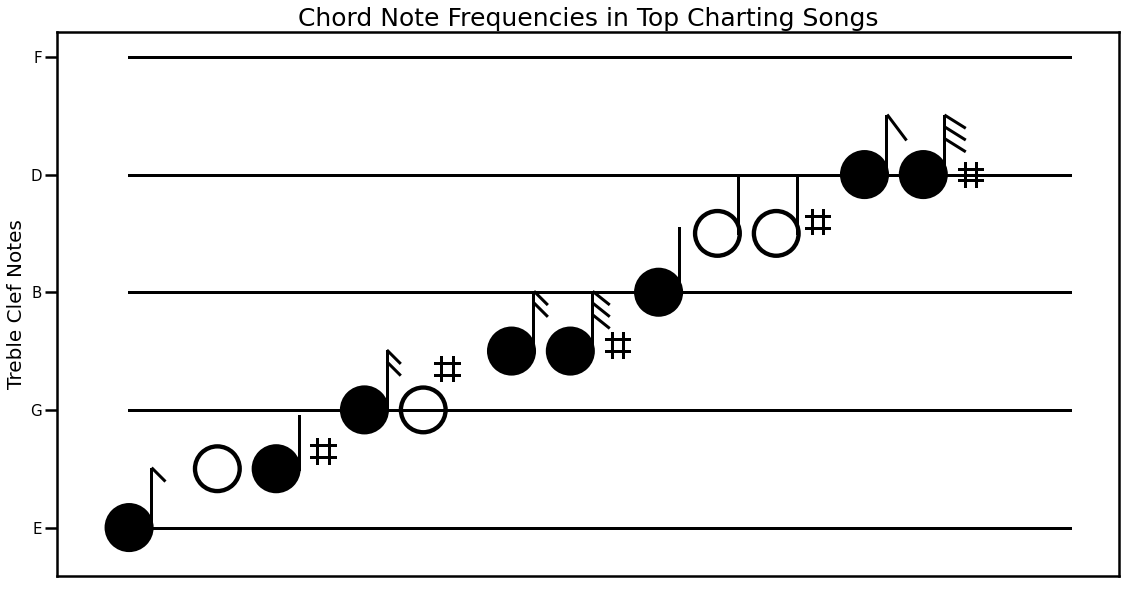

In [29]:
# figure:
fig = plt.figure()
ax = fig.gca()
ax.grid(False)
ax.set_aspect("equal")
ax.set_facecolor('w')

fig2 = plt.gcf()
fig2.set_size_inches(20, 10)

# plotting:
plt.plot([0,8],[5,5], color = 'k')
plt.plot([0,8],[4,4], color = 'k')
plt.plot([0,8],[3,3], color = 'k')
plt.plot([0,8],[2,2], color = 'k')
plt.plot([0,8],[1,1], color = 'k')

# notes
ax.add_patch(plt.Circle((0, 1), 0.2, color = 'k')) # E - eighth
plt.plot([0.19, 0.19], [1, 1.5], color = 'k', linewidth = 3) # add line
plt.plot([0.3, 0.2], [1.4, 1.5], color = 'k', linewidth = 3) # add flag

ax.add_patch(plt.Circle((0.75, 1.5), 0.2, color='k')) # F - whole (open)
ax.add_patch(plt.Circle((0.75, 1.5), 0.18, edgecolor='k', facecolor='w')) 

ax.add_patch(plt.Circle((1.25, 1.5), 0.2, color = 'k')) # F sharp - quarter
plt.plot([1.44, 1.44], [1.5, 1.95], color = 'k', linewidth = 3) # add line
# sharp symbol
plt.plot([1.6, 1.6], [1.55, 1.75], color = 'k') # vertical
plt.plot([1.7, 1.7], [1.55, 1.75], color = 'k') # vertical
plt.plot([1.55, 1.75], [1.7, 1.7], color = 'k') # horizontal
plt.plot([1.55, 1.75], [1.6, 1.6], color = 'k') # horizontal

ax.add_patch(plt.Circle((2, 2), 0.2, color = 'k')) # G - sixteenth
plt.plot([2.19, 2.19], [2, 2.5], color = 'k', linewidth = 3) # add line
plt.plot([2.2, 2.3], [2.5, 2.4], color = 'k', linewidth = 3) # add flag
plt.plot([2.2, 2.3], [2.4, 2.3], color = 'k', linewidth = 3) # add flag 2

ax.add_patch(plt.Circle((2.5, 2), 0.2, color = 'k')) # G sharp - whole
ax.add_patch(plt.Circle((2.5, 2), 0.18, edgecolor='k', facecolor='w')) 
# sharp symbol
plt.plot([2.65, 2.65], [2.25, 2.45], color = 'k') # vertical
plt.plot([2.75, 2.75], [2.25, 2.45], color = 'k') # vertical
plt.plot([2.6, 2.8], [2.3, 2.3], color = 'k') # horizontal
plt.plot([2.6, 2.8], [2.4, 2.4], color = 'k') # horizontal

ax.add_patch(plt.Circle((3.25, 2.5), 0.2, color = 'k')) # A - sixteenth
plt.plot([3.43, 3.43], [2.5, 3], color = 'k', linewidth = 3) # add line
plt.plot([3.55, 3.45], [2.9, 3], color = 'k', linewidth = 3) # add flag
plt.plot([3.55, 3.45], [2.8, 2.9], color = 'k', linewidth = 3) # add flag 2

ax.add_patch(plt.Circle((3.75, 2.5), 0.2, color = 'k')) # A sharp - thirtysecond
plt.plot([3.93, 3.93], [2.5, 3], color = 'k', linewidth = 3) # add line
plt.plot([4.075, 3.95], [2.9, 3], color = 'k', linewidth = 3) # add flag
plt.plot([4.075, 3.95], [2.8, 2.9], color = 'k', linewidth = 3) # add flag 2
plt.plot([4.075, 3.95], [2.7, 2.8], color = 'k', linewidth = 3) # add flag 3
# sharp symbol
plt.plot([4.1, 4.1], [2.45, 2.65], color = 'k') # vertical
plt.plot([4.2, 4.2], [2.45, 2.65], color = 'k') # vertical
plt.plot([4.05, 4.25], [2.5, 2.5], color = 'k') # horizontal
plt.plot([4.05, 4.25], [2.6, 2.6], color = 'k') # horizontal

ax.add_patch(plt.Circle((4.5, 3), 0.2, color = 'k')) # B - quarter
plt.plot([4.675, 4.675], [3.07, 3.55], color = 'k', linewidth = 3) # add line

ax.add_patch(plt.Circle((5, 3.5), 0.2, color = 'k')) # C - half
ax.add_patch(plt.Circle((5, 3.5), 0.18, edgecolor='k', facecolor='w')) # open
plt.plot([5.175, 5.175], [3.5, 4], color = 'k', linewidth = 3) # add line

ax.add_patch(plt.Circle((5.5, 3.5), 0.2, color = 'k')) # C sharp - half
ax.add_patch(plt.Circle((5.5, 3.5), 0.18, edgecolor='k', facecolor='w')) # open
plt.plot([5.677, 5.677], [3.5, 4], color = 'k', linewidth = 3) # add line
# sharp symbol
plt.plot([5.8, 5.8], [3.5, 3.7], color = 'k') # vertical
plt.plot([5.9, 5.9], [3.5, 3.7], color = 'k') # vertical
plt.plot([5.75, 5.95], [3.55, 3.55], color = 'k') # horizontal
plt.plot([5.75, 5.95], [3.65, 3.65], color = 'k') # horizontal

ax.add_patch(plt.Circle((6.25, 4), 0.2, color = 'k')) # D - eighth
plt.plot([6.43, 6.43], [4, 4.5], color = 'k', linewidth = 3) # add line
plt.plot([6.6, 6.45], [4.3, 4.5], color = 'k', linewidth = 3) # add flag

ax.add_patch(plt.Circle((6.75, 4), 0.2, color = 'k')) # D sharp - thirtysecond
plt.plot([6.93, 6.93], [4, 4.5], color = 'k', linewidth = 3) # add line
plt.plot([7.1, 6.94], [4.4, 4.5], color = 'k', linewidth = 3) # add flag
plt.plot([7.1, 6.94], [4.3, 4.4], color = 'k', linewidth = 3) # add flag 2
plt.plot([7.1, 6.94], [4.2, 4.3], color = 'k', linewidth = 3) # add flag 3
# sharp symbol
plt.plot([7.1, 7.1], [3.9, 4.1], color = 'k') # vertical
plt.plot([7.2, 7.2], [3.9, 4.1], color = 'k') # vertical
plt.plot([7.05, 7.25], [3.95, 3.95], color = 'k') # horizontal
plt.plot([7.05, 7.25], [4.05, 4.05], color = 'k') # horizontal

#use yticks to show notes (for those that don't know)
plt.yticks([1, 2, 3, 4, 5], ['E', 'G', 'B', 'D', 'F'], size=15)
plt.xticks([])
plt.ylabel('Treble Clef Notes', size=20)
plt.title('Chord Note Frequencies in Top Charting Songs', size=25)
plt.show()